# Gender/Age Bias for Movie Ratings Using AIF360

## Import Statements

In [1]:
# !pip uninstall -y numpy

In [2]:
# !pip install numpy

In [3]:
!pip install scikit-surprise

In [4]:
import random
from sklearn import linear_model
from matplotlib import pyplot as plt
from collections import defaultdict
import gzip
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import json
import numpy
import dateutil.parser
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.optimize
from sklearn import svm
import string
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
# from implicit.als import AlternatingLeastSquares
import numpy as np
import os
import tarfile

In [5]:
#Install AIF360
!pip install 'aif360'

ERROR: Invalid requirement: "'aif360'"


In [6]:
# Install TensorFlow
!pip install 'tensorflow==2.6.0'

ERROR: Invalid requirement: "'tensorflow==2.6.0'"


In [7]:
pip install 'aif360[LawSchoolGPA]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[LawSchoolGPA]'"


In [8]:
pip install --upgrade tensorflow aif360

  Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl.metadata (540 bytes)
Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl (422 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install protobuf==3.19.0

  Using cached protobuf-3.19.0-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 3.19.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.0 which is incompatible.


In [10]:
pip install 'aif360[AdversarialDebiasing]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[AdversarialDebiasing]'"


In [11]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## Reading File Path

In [12]:
# Update the file paths based on your extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Users File
users_file = os.path.join(extract_path, "users.dat")
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users_df = pd.read_csv(users_file, sep="::", engine="python", header=None, names=users_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

## Checking for Null Values for Each Dataframe

In [13]:
# Check for null values in Ratings file
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [14]:
# Check for null values in Users file
users_df.isnull().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [15]:
# Check for null values in Movies file

movies_df.isnull().sum()

MovieID    0
Title      0
Genres     0
dtype: int64

## Ratings Dataframe EDA

Text(0, 0.5, 'Count')

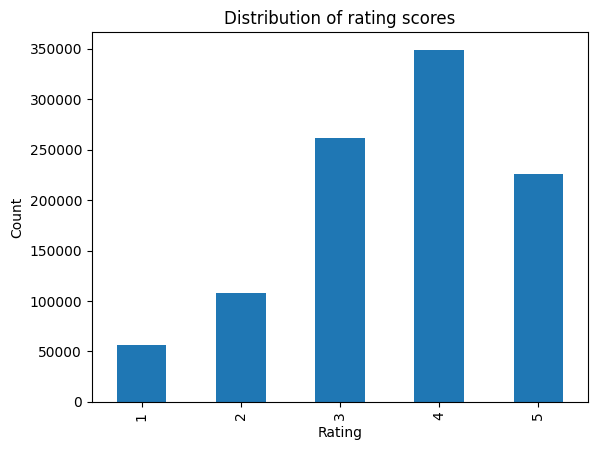

In [16]:
# Plot distribution of rating scores
ratings_df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating scores')
plt.ylabel('Count')

# There do not appear to be any placeholders for missing vals
# Most ratings are 4 stars, the least amount of ratings are 1 star

Text(0, 0.5, 'Count')

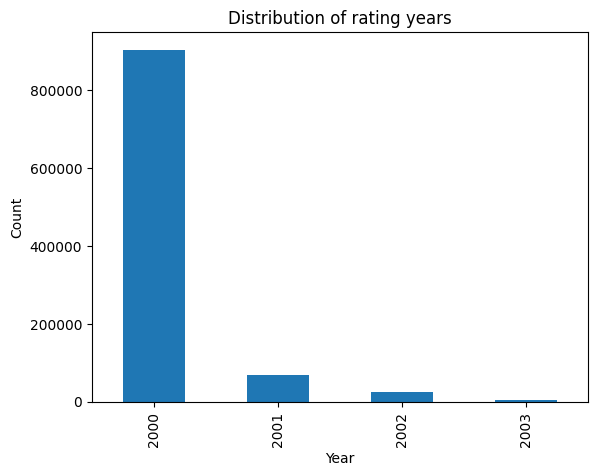

In [17]:
# Convert Timestamp col to datetime objects for visualizations
datetime = pd.to_datetime(ratings_df['Timestamp'], unit='s')

# Plot year of rating
datetime.dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating years')
plt.xlabel('Year')
plt.ylabel('Count')

# Almost all ratings are from 2000

Text(0, 0.5, 'Count')

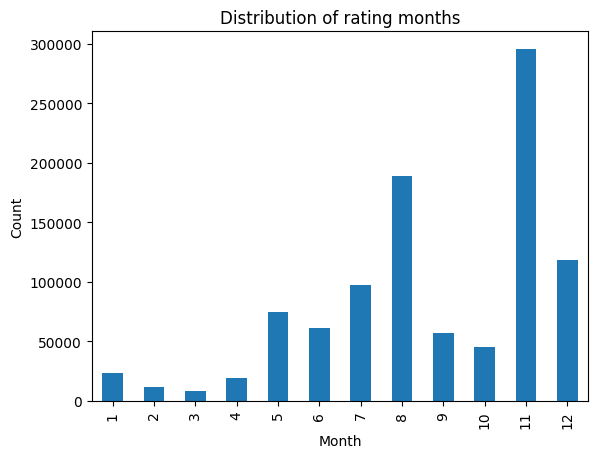

In [18]:
# Plot months of rating
datetime.dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating months')
plt.xlabel('Month')
plt.ylabel('Count')

# Most ratings are from November

Text(0, 0.5, 'Count')

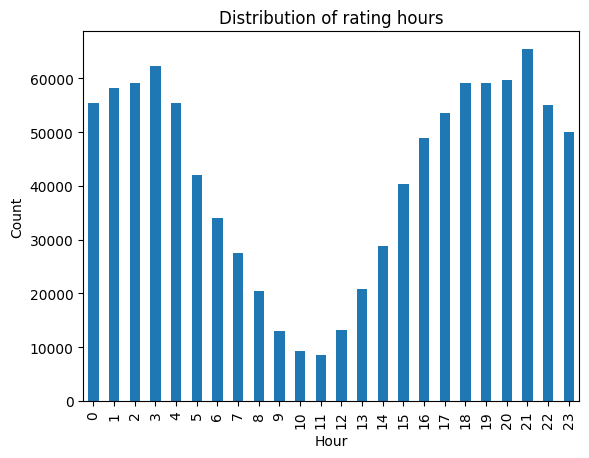

In [19]:
# Plot hour of rating
datetime.dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating hours')
plt.xlabel('Hour')
plt.ylabel('Count')

# Most ratings happen at the beginning of the day or the end, as that's where peaks happen.

In [20]:
# There do not appear to be any placeholders for null values
ratings_df['UserID'].min(), ratings_df['UserID'].max()

(1, 6040)

In [21]:
# Top 5 user IDs who left the most ratings
ratings_df['UserID'].value_counts()[:5]

UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64

In [22]:
# There do not appear to be any placeholders for null values
ratings_df['MovieID'].min(), ratings_df['MovieID'].max()

(1, 3952)

In [23]:
# Top 5 movie IDs with the most ratings
ratings_df['MovieID'].value_counts()[:5]

MovieID
2858    3428
260     2991
1196    2990
1210    2883
480     2672
Name: count, dtype: int64

## Merge Dataframes

In [24]:
merged_df = ratings_df.merge(users_df[['UserID', 'Age', 'Gender', 'Occupation']], on='UserID')

In [25]:
merged_df['Gender'] = merged_df['Gender'].replace({'F': 0, 'M': 1})

In [26]:
merged_df

,UserID,MovieID,Rating,Timestamp,Age,Gender,Occupation
0,1,1193,5,978300760,1,0,10
1,1,661,3,978302109,1,0,10
2,1,914,3,978301968,1,0,10
3,1,3408,4,978300275,1,0,10
4,1,2355,5,978824291,1,0,10
...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,25,1,6
1000205,6040,1094,5,956704887,25,1,6
1000206,6040,562,5,956704746,25,1,6
1000207,6040,1096,4,956715648,25,1,6


## Bias EDA

Sum of Star Ratings per Unique Age:
Rating      1      2       3       4      5
Age                                        
1        2238   2983    6380    8808   6802
18      13063  22073   47601   60241  40558
25      23898  44817  104287  136824  85730
35       9067  20253   52990   71983  44710
45       3409   8437   22311   30334  19142
50       2948   5993   18465   26484  18600
56       1551   3001    9163   14297  10768


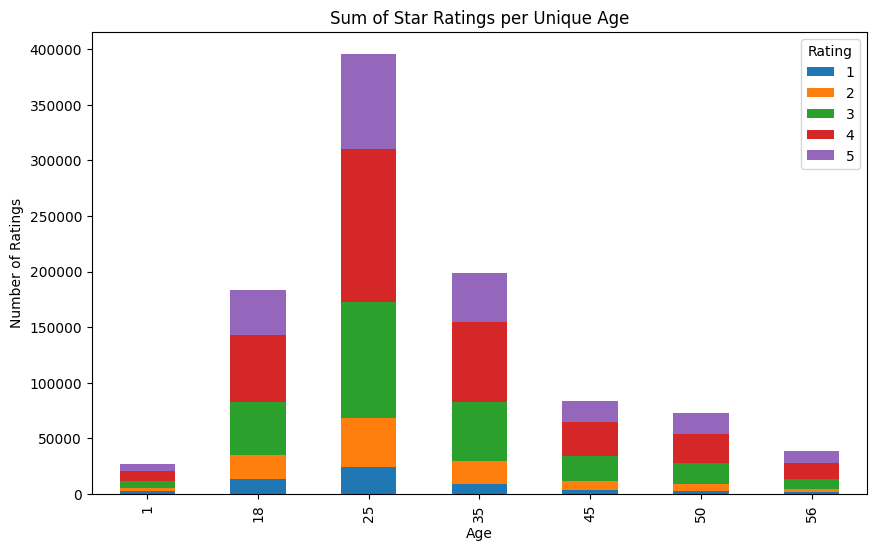

In [27]:
# Group by Age and Rating, then calculate the sum
grouped_data = merged_df.groupby(['Age', 'Rating']).size().unstack().fillna(0)

# Print the specific values
print("Sum of Star Ratings per Unique Age:")
print(grouped_data)

# Plot the bar plot
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Age')
plt.ylabel('Number of Ratings')
plt.title('Sum of Star Ratings per Unique Age')

# Show the plot
plt.show()

Sum of Star Ratings per Gender:
Rating      1      2       3       4       5
Gender                                      
0       13347  24548   62966   87033   58546
1       42827  83009  198231  261938  167764


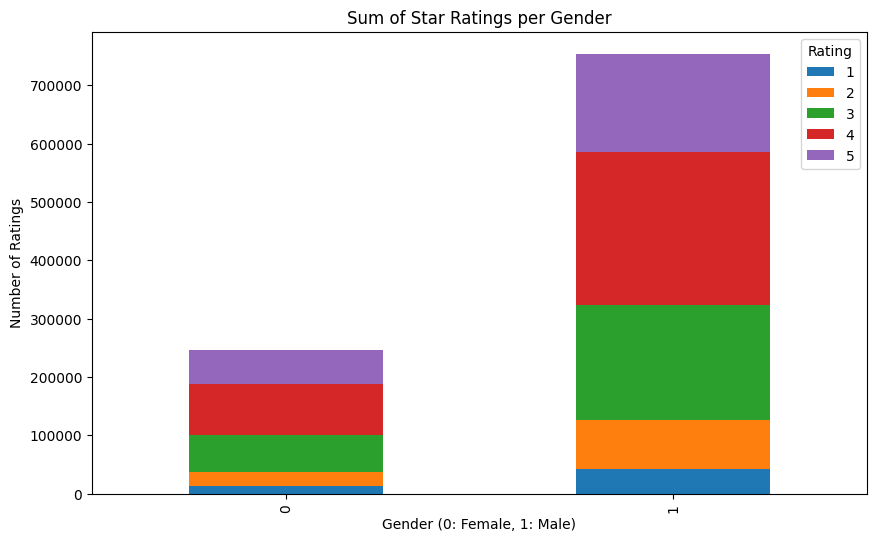

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named merged_df
# If not, you can replace merged_df with your DataFrame name

# Group by Gender and Rating, then calculate the sum
grouped_data_gender = merged_df.groupby(['Gender', 'Rating']).size().unstack().fillna(0)

# Print the specific values
print("Sum of Star Ratings per Gender:")
print(grouped_data_gender)

# Plot the bar plot
grouped_data_gender.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Number of Ratings')
plt.title('Sum of Star Ratings per Gender')

# Show the plot
plt.show()

## Checking for Bias with AIF360

In [29]:
print(merged_df['Age'].unique())

[ 1 56 25 45 50 35 18]


In [30]:
# # Assuming 'merged_df' is your DataFrame containing the data
# # Choose relevant columns for features and labels
# features = ['Age', 'Gender', 'Occupation']  # Include other relevant features
# label = 'Rating'

# # Split the dataset into training and testing sets
# train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# # Create StandardDatasets for training and testing
# train_dataset = StandardDataset(train_df, label_name=label, favorable_classes=[5],
#                                 protected_attribute_names=['Age'], privileged_classes=[[1]])
# test_dataset = StandardDataset(test_df, label_name=label, favorable_classes=[5],
#                                protected_attribute_names=['Age'], privileged_classes=[[1]])


# # Initialize and train the linear regression model
# lr_model = LinearRegression()
# lr_model.fit(train_dataset.features, train_dataset.labels.ravel())


# # Make predictions on the test set
# test_predictions = lr_model.predict(test_dataset.features)

# # Evaluate the performance (e.g., mean squared error)
# mse = mean_squared_error(test_dataset.labels, test_predictions)
# print("Mean Squared Error:", mse)

# # Calculate the disparate impact before any mitigation
# metric_before = BinaryLabelDatasetMetric(test_dataset, unprivileged_groups=[{'Age': 0}], privileged_groups=[{'Age': 1}])
# disparate_impact_before = metric_before.disparate_impact()
# print("Disparate Impact Before Mitigation:", disparate_impact_before)

# # Apply Disparate Impact Remover as a mitigation technique
# di_removal = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='Age')
# test_dataset_transformed = di_removal.fit_transform(test_dataset)

# # Calculate the disparate impact after mitigation
# metric_after = BinaryLabelDatasetMetric(test_dataset_transformed, unprivileged_groups=[{'Age': 0}], privileged_groups=[{'Age': 1}])
# disparate_impact_after = metric_after.disparate_impact()
# print("Disparate Impact After Mitigation:", disparate_impact_after)

### Checking for Bias When Age >= 56

In [32]:
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attributes
protected_attributes = ['Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_df, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[lambda x: x >= 56])  # Assuming 56 indicates privileged class

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'Age': 0}], privileged_groups=[{'Age': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Disparate Impact Remover as a mitigation technique
privileged_groups = [{'Age': 1}]
unprivileged_groups = [{'Age': 0}]

rw = Reweighing(unprivileged_groups=[{'Age': 0}], privileged_groups=[{'Age': 1}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 0.8073975893273045
Disparate Impact After Mitigation: 1.0000000000000007


#### Analysis: 
- Privileged Group (Males, Age >= 56)
- Unprivileged Group (Females, Age < 56):
- Disparate Impact Before Mitigation (0.8074):
  - Interpretation: Females (age less than 56) are less likely to give high ratings compared to males (age greater than or equal to 56) before mitigation.

In [33]:
#Now switching underpriviledged group

# Define the protected attributes
protected_attributes = ['Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_df, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[lambda x: x >= 56])  # Assuming 56 indicates privileged class

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'Age': 1}], privileged_groups=[{'Age': 0}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Disparate Impact Remover as a mitigation technique
privileged_groups = [{'Age': 0}]
unprivileged_groups = [{'Age': 1}]

rw = Reweighing(unprivileged_groups=[{'Age': 1}], privileged_groups=[{'Age': 0}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 1.2385471708345885
Disparate Impact After Mitigation: 0.9999999999999992


- Privileged Group (Females, Age >= 56)
- Unprivileged Group (Males, Age < 56):
- Disparate Impact Before Mitigation (1.2437):
  - Interpretation: Males (age less than 56) are more likely to give high ratings compared to females (age greater than or equal to 56) before mitigation.

#### TESTING

In [34]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Define the protected attributes
protected_attributes = ['Gender', 'Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_df, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=([1, 1], [25, 25]))

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'Gender': 0, 'Age': 56}],
                                         privileged_groups=[{'Gender': 1, 'Age': 25}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Disparate Impact Remover separately for each sensitive attribute
di_removal_gender = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='Gender')
di_removal_age = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='Age')

dataset_transformed = di_removal_gender.fit_transform(dataset)
dataset_transformed = di_removal_age.fit_transform(dataset_transformed)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'Gender': 0, 'Age': 56}],
                                        privileged_groups=[{'Gender': 1, 'Age': 25}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 1.5808932997581773
Disparate Impact After Mitigation: 1.5808932997581773


Privileged Group (Males, Age = 25)
Unprivileged Group (Females, Age = 1)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target variable and other columns are features
features = dataset_transformed.features
labels = dataset_transformed.labels.flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Initialize and train the linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1736178028954279


In [36]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Define the protected attributes
protected_attributes = ['Gender', 'Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_df, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=([1, 1], [25, 25]))

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'Gender': 0, 'Age': 56}],
                                         privileged_groups=[{'Gender': 1, 'Age': 25}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'Gender': 0, 'Age': 56}], privileged_groups=[{'Gender': 1, 'Age': 25}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'Gender': 0, 'Age': 56}],
                                        privileged_groups=[{'Gender': 1, 'Age': 25}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 1.5808932997581773
Disparate Impact After Mitigation: 1.0000000000000002


In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_transformed.features, dataset_transformed.labels.flatten(), test_size=0.2)

# Initialize and train the linear regression model on the transformed data
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.17412443451826862
